In [1]:
# this is specific to macos X , windows/linux users dont need this 
# without this , while using xgboost , you get errors , kernel dies
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import math as mt

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

In [5]:
import tensorflow as tf
import tensorflow.python.keras as keras

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,Input

In [6]:
from rfpimp import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error

## Coding categorical features as dummies 

In [7]:
def code_categorical_to_dummies(dt,columns,freq_cutoff=0):
    data=dt.copy()
    for col in columns:
        
        freq_table=data[col].value_counts(dropna=False)
        
        if (freq_table<freq_cutoff).sum()==0:
            cats=freq_table.index[:-1]
        else:
            cats=freq_table.index[freq_table>freq_cutoff]
        
        for cat in cats:
            data[col+'_'+str(cat)]=(data[col]==cat).astype(int)
        
        del data[col]
        
        
    return data

### Pipeline friendly class

In [8]:
class get_dummies_Pipe(BaseEstimator, TransformerMixin):
    
    def __init__(self,freq_cutoff=0):
        self.freq_cutoff=freq_cutoff
        self.var_cat_dict={}
        
    def fit(self,x,y=None):
        data_cols=x.columns
        for col in data_cols:
            freq_table=x[col].value_counts(dropna=False)
            if (freq_table<self.freq_cutoff).sum()==0:
                cats=freq_table.index[:-1]
            else:
                cats=freq_table.index[freq_table>self.freq_cutoff]
            self.var_cat_dict[col]=cats
        return self
            
    def transform(self,x,y=None):
        dummy_data=x.copy()
        for col in self.var_cat_dict.keys():
            for cat in self.var_cat_dict[col]:
                name=col+'_'+str(cat)
                dummy_data[name]=(dummy_data[col]==cat).astype(int)
            del dummy_data[col]
        return dummy_data

In [9]:
d1=pd.DataFrame({'x':['a','b','a','b','c','c']})
d2=pd.DataFrame({'x':['a','b','a','b','c','c','d','d','d']})

In [10]:
code_categorical_to_dummies(d1,'x')

,x_a,x_b
0,1,0
1,0,1
2,1,0
3,0,1
4,0,0
5,0,0


In [11]:
code_categorical_to_dummies(d2,'x')

,x_d,x_a,x_b
0,0,1,0
1,0,0,1
2,0,1,0
3,0,0,1
4,0,0,0
5,0,0,0
6,1,0,0
7,1,0,0
8,1,0,0


In [12]:
gd=get_dummies_Pipe()

In [13]:
gd.fit(d1)

get_dummies_Pipe()

In [14]:
gd.var_cat_dict

{'x': Index(['a', 'b'], dtype='object')}

In [15]:
gd.transform(d1)

,x_a,x_b
0,1,0
1,0,1
2,1,0
3,0,1
4,0,0
5,0,0


In [16]:
gd.transform(d2)

,x_a,x_b
0,1,0
1,0,1
2,1,0
3,0,1
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0


## Categorical Embeddings

In [17]:

file = r'../data/loans data.csv'
data=pd.read_csv(file)
data['State'].nunique()

47

In [18]:
dummy_data=pd.get_dummies(data['State'],prefix='State')
dummy_data.shape[1]

47

In [19]:
y=dummy_data

In [55]:
dummy_data

,State_.,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,...,State_SC,State_SD,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
y

,State_.,State_AK,State_AL,State_AR,State_AZ,State_CA,State_CO,State_CT,State_DC,State_DE,...,State_SC,State_SD,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2496,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2497,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2498,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
data['State'].nunique()

47

In [22]:
y.shape

(2500, 47)

In [23]:
embedding_dim=3

inputs=Input(shape=(dummy_data.shape[1],))

dense1=Dense(20,activation='relu')(inputs)

embedded_output=Dense(embedding_dim)(dense1)

outputs=Dense(dummy_data.shape[1],activation='softmax')(embedded_output)
model=Model(inputs=inputs,outputs=outputs)

embedder=Model(inputs=inputs,outputs=embedded_output)

In [24]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(dummy_data,y,epochs=150,batch_size=100)

Train on 2500 samples
Epoch 1/150
2500/2500 [==============================] - 0s 136us/sample - loss: 3.8197 - accuracy: 0.0676
Epoch 2/150
2500/2500 [==============================] - 0s 27us/sample - loss: 3.7680 - accuracy: 0.0676
Epoch 3/150
2500/2500 [==============================] - 0s 29us/sample - loss: 3.7040 - accuracy: 0.0676
Epoch 4/150
2500/2500 [==============================] - 0s 26us/sample - loss: 3.6159 - accuracy: 0.0676
Epoch 5/150
2500/2500 [==============================] - 0s 30us/sample - loss: 3.4934 - accuracy: 0.0700
Epoch 6/150
2500/2500 [==============================] - 0s 30us/sample - loss: 3.3362 - accuracy: 0.1060
Epoch 7/150
2500/2500 [==============================] - 0s 30us/sample - loss: 3.1483 - accuracy: 0.1060
Epoch 8/150
2500/2500 [==============================] - 0s 31us/sample - loss: 2.9367 - accuracy: 0.2528
Epoch 9/150
2500/2500 [==============================] - 0s 28us/sample - loss: 2.7040 - accuracy: 0.3356
Epoch 10/150
2500/2500 

In [25]:
low_dim=pd.DataFrame(embedder.predict(dummy_data),columns=['emb1','emb2','emb3'])
low_dim.head()

,emb1,emb2,emb3
0,-4.976855,-7.442372,29.894251
1,-22.394285,-6.660918,-19.112335
2,-14.428508,7.807920,-19.909124
3,6.584114,0.236790,34.191406
4,26.340851,3.233644,9.454779


In [26]:
low_dim

,emb1,emb2,emb3
0,-4.976855,-7.442372,29.894251
1,-22.394285,-6.660918,-19.112335
2,-14.428508,7.807920,-19.909124
3,6.584114,0.236790,34.191406
4,26.340851,3.233644,9.454779
...,...,...,...
2495,9.124255,-6.047707,-28.230549
2496,-7.562596,-27.605417,-1.169847
2497,-5.693480,-12.076904,-28.776634
2498,26.340851,3.233644,9.454778


In [27]:
data['State']

0       SC
1       TX
2       CA
3       KS
4       NJ
        ..
2495    NY
2496    MD
2497    PA
2498    NJ
2499    NY
Name: State, Length: 2500, dtype: object

## Coding cyclic time features 

In [28]:
import numpy as np

In [29]:
months=np.arange(1,13)
months

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [30]:
months_sin=np.sin(2*np.pi*months/12)

[]

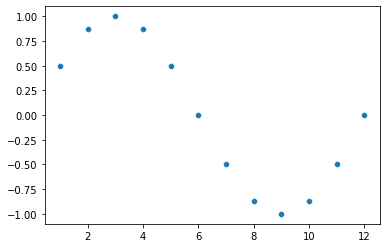

In [32]:
sns.scatterplot(x=months,y=months_sin).plot()

In [33]:
months_sin

array([ 5.00000000e-01,  8.66025404e-01,  1.00000000e+00,  8.66025404e-01,
        5.00000000e-01,  1.22464680e-16, -5.00000000e-01, -8.66025404e-01,
       -1.00000000e+00, -8.66025404e-01, -5.00000000e-01, -2.44929360e-16])

In [34]:
months_cos=np.cos(2*np.pi*months/12)

[]

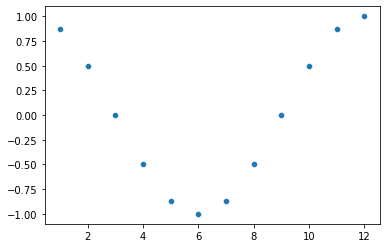

In [56]:
sns.scatterplot(x=months,y=months_cos).plot()

In [35]:
months_sin

array([ 5.00000000e-01,  8.66025404e-01,  1.00000000e+00,  8.66025404e-01,
        5.00000000e-01,  1.22464680e-16, -5.00000000e-01, -8.66025404e-01,
       -1.00000000e+00, -8.66025404e-01, -5.00000000e-01, -2.44929360e-16])

In [36]:
months_cos

array([ 8.66025404e-01,  5.00000000e-01,  6.12323400e-17, -5.00000000e-01,
       -8.66025404e-01, -1.00000000e+00, -8.66025404e-01, -5.00000000e-01,
       -1.83697020e-16,  5.00000000e-01,  8.66025404e-01,  1.00000000e+00])

[]

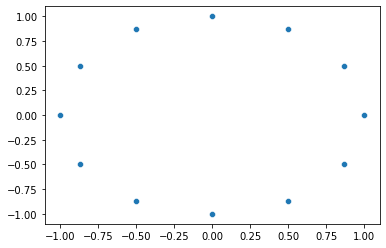

In [37]:
sns.scatterplot(x=months_sin,y=months_cos).plot()

In [38]:
def code_cyclic_features(data,columns,drop_cols=True):
    for col in columns:
        max_val=max(data[col])

        data[col+'_sin']=np.sin(2*np.pi*data[col]/max_val)
        data[col+'_cos']=np.cos(2*np.pi*data[col]/max_val)

        if drop_cols:
            del data[col]
    return data  

## Revisiting feature importance and issue with default importance in sklearn

In [39]:
data.head()

,ID,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Loan.Length,Loan.Purpose,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length
0,81174.0,20000,20000,8.90%,36 months,debt_consolidation,14.90%,SC,MORTGAGE,6541.67,735-739,14,14272,2.0,< 1 year
1,99592.0,19200,19200,12.12%,36 months,debt_consolidation,28.36%,TX,MORTGAGE,4583.33,715-719,12,11140,1.0,2 years
2,80059.0,35000,35000,21.98%,60 months,debt_consolidation,23.81%,CA,MORTGAGE,11500.00,690-694,14,21977,1.0,2 years
3,15825.0,10000,9975,9.99%,36 months,debt_consolidation,14.30%,KS,MORTGAGE,3833.33,695-699,10,9346,0.0,5 years
4,33182.0,12000,12000,11.71%,36 months,credit_card,18.78%,NJ,RENT,3195.00,695-699,11,14469,0.0,9 years


In [40]:
data.drop(['ID','Amount.Funded.By.Investors'],axis=1,inplace=True)

for col in ['Interest.Rate','Debt.To.Income.Ratio']:
    data[col]=data[col].str.replace("%","")
    
    

for col in ['Amount.Requested', 'Interest.Rate','Debt.To.Income.Ratio',
            'Open.CREDIT.Lines','Revolving.CREDIT.Balance']:
    data[col]=pd.to_numeric(data[col],errors='coerce')
    

k=data['FICO.Range'].str.split("-",expand=True).astype(float)

data['fico']=0.5*(k[0]+k[1])

del data['FICO.Range']

cat_cols=data.select_dtypes(['object']).columns

data=code_categorical_to_dummies(data,cat_cols)

for col in data.columns:
    if data[col].isnull().sum()>0:
        data.loc[data[col].isnull(),col]=data[col].mean()

In [41]:
x_train=data.drop(['Interest.Rate'],1)
y_train=data['Interest.Rate']

In [42]:
x_train.shape

(2500, 88)

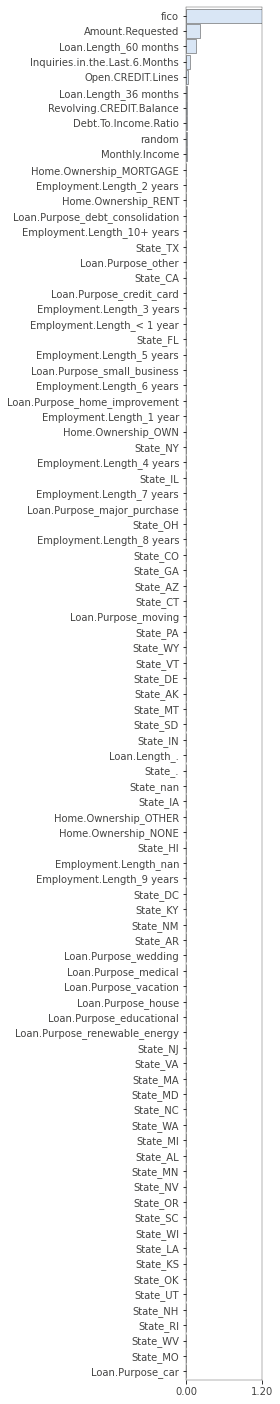

In [43]:
# Add column of random numbers
x_train['random'] = np.random.random(size=len(x_train))


rf = RandomForestRegressor(n_estimators=100,
                            min_samples_leaf=5,
                            n_jobs=-1,
                            oob_score=True)

rf.fit(x_train,y_train)

imp = importances(rf, x_train, y_train, n_samples=-1) # this function comes from package rfpimp
viz = plot_importances(imp)
viz.view()

# it is possible that with different iterations of the code result in features at boundary switch to other side
# dont worry about that , they dont make much difference either way [ and you have to draw a line somewhere]

In [58]:
imp.head(10)

,Importance
Feature,
fico,1.193433
Amount.Requested,0.221510
Loan.Length_60 months,0.159601
Inquiries.in.the.Last.6.Months,0.060287
Open.CREDIT.Lines,0.033778
Loan.Length_36 months,0.016183
Revolving.CREDIT.Balance,0.015089
Debt.To.Income.Ratio,0.014111
random,0.014057


## Transformed Features : capability of algos to capture transformation automatically

In [45]:
x_data= pd.DataFrame(np.random.random(size= (4000,5)), columns= ['x1','x2','x3','x4','x5'])

x_data.shape

(4000, 5)

In [59]:
x_data

,x1,x2,x3,x4,x5,y1,y2,y3,y4,y5
0,0.301834,0.580511,0.329736,0.406169,0.983240,4.754025,3.583185,-1.563793,13.204920,8.289432
1,0.175717,0.679870,0.853405,0.856519,0.731263,5.533728,4.329968,-0.842600,12.565013,9.336953
2,0.906641,0.999096,0.687693,0.928549,0.365208,5.654358,4.872774,0.423369,9.218477,5.508332
3,0.296361,0.240768,0.735469,0.635115,0.285333,4.066268,2.843778,-3.029912,15.876551,6.797112
4,0.537405,0.141214,0.649086,0.888433,0.154980,4.700510,3.905303,-2.536986,20.352390,8.509961
...,...,...,...,...,...,...,...,...,...,...
3995,0.621829,0.479377,0.138632,0.659286,0.391646,3.871902,3.349540,-2.129132,16.656959,7.988575
3996,0.644107,0.844558,0.379806,0.124585,0.058519,4.018049,3.383937,-4.426608,32.256522,4.110525
3997,0.175684,0.587117,0.593589,0.089405,0.869300,4.045523,3.790324,-3.032290,23.281434,16.191200
3998,0.954057,0.937841,0.803626,0.145727,0.436221,5.429764,4.546908,-1.244489,14.033729,7.161855


In [46]:
# Linear Output
x_data['y1']= 1.5 + x_data['x1'] + x_data['x2'] + x_data['x3'] + x_data['x4'] + x_data['x5'] + np.random.random(size=4000)

# Exponential Output
x_data['y2']= 1.5 + (x_data['x1']**2) + (x_data['x2']**2) + (x_data['x3']**2) + (x_data['x4']**2) + (x_data['x5']**2) + np.random.random(size=4000)

# Log Output
x_data['y3']= 1.5 + (np.log(x_data['x1'])) + (np.log(x_data['x2'])) + (np.log(x_data['x3'])) + (np.log(x_data['x4'])) + (np.log(x_data['x5'])) + np.random.random(size=4000)

# Inverse Transformation
x_data['y4']= 1.5 + (1/x_data['x1']) + (1/x_data['x2']) + (1/x_data['x3']) + (1/x_data['x4']) + (1/x_data['x5']) + np.random.random(size=4000)

# Division Transformation
x_data['y5']= 1.5 + (x_data['x2']/x_data['x1'])  + (x_data['x3']/x_data['x2'])  + (x_data['x4']/x_data['x3']) + (x_data['x5']/x_data['x4']) + np.random.random(size=4000)

x_data.head(5)

,x1,x2,x3,x4,x5,y1,y2,y3,y4,y5
0,0.301834,0.580511,0.329736,0.406169,0.983240,4.754025,3.583185,-1.563793,13.204920,8.289432
1,0.175717,0.679870,0.853405,0.856519,0.731263,5.533728,4.329968,-0.842600,12.565013,9.336953
2,0.906641,0.999096,0.687693,0.928549,0.365208,5.654358,4.872774,0.423369,9.218477,5.508332
3,0.296361,0.240768,0.735469,0.635115,0.285333,4.066268,2.843778,-3.029912,15.876551,6.797112
4,0.537405,0.141214,0.649086,0.888433,0.154980,4.700510,3.905303,-2.536986,20.352390,8.509961


In [47]:

train, test= train_test_split(x_data, test_size= 0.2, random_state=2)

x_train= train.drop(['y1','y2','y3','y4','y5'],1)
y_train= train[['y1','y2','y3','y4','y5']]

x_test= test.drop(['y1','y2','y3','y4','y5'],1)
y_test= test[['y1','y2','y3','y4','y5']]

results= pd.DataFrame(columns=["Algo","Relation","MAE"])

In [48]:
def Random_Forest(x,y,relation):
    
    rf= RandomForestRegressor(n_estimators=200)
    rf.fit(x,y_train[y])
    y_pred=rf.predict(x_test)
    mae= np.round(mean_absolute_error(y_test[y],y_pred),4)
    global results
    results= results.append({'Algo':"Random Forest",'Relation':relation,'MAE':mae}, ignore_index=True)
    
    #return(print("Algo: Random Forest\nRelation: "+relation+" \nMean Absolute error: ",mean_absolute_error(y_test[y],y_pred)))
    

def SV_M (x,y, relation):
    svr= SVR()
    svr.fit(x,y_train[y])
    y_pred=svr.predict(x_test)
    mae= np.round(mean_absolute_error(y_test[y],y_pred),4)
    global results
    results= results.append({'Algo':"SVM",'Relation':relation,'MAE':mae}, ignore_index=True)
   # return(print("Algo: SVM \nRelation: "+relation+" \nMean Absolute error: ",mean_absolute_error(y_test[y],y_pred)))

def XG_B(x,y, relation):
    xgb= XGBRegressor(n_estimators=200,learning_rate=.01,objective='reg:squarederror')
    xgb.fit(x,y_train[y])
    y_pred=xgb.predict(x_test)
    mae= np.round(mean_absolute_error(y_test[y],y_pred),4)
    global results
    results= results.append({'Algo':"XGB",'Relation':relation,'MAE':mae}, ignore_index=True)
   # return(print("Algo: XGB \nRelation: "+relation+" \nMean Absolute error: ",mean_absolute_error(y_test[y],y_pred)))

In [49]:
# SET-1 (x)

Random_Forest(x_train,"y1","x")

SV_M(x_train,"y1","x")

XG_B(x_train,"y1","x")

In [50]:
# SET-2 (x^2)

Random_Forest(x_train,"y2","x^2")

SV_M(x_train,"y2","x^2")

XG_B(x_train,"y2","x^2")



In [51]:
# SET-3 (log(x))
Random_Forest(x_train,"y3","log(x)")

SV_M(x_train,"y3","log(x)")

XG_B(x_train,"y3","log(x)")



In [52]:
# SET-4 (Inverse)
Random_Forest(x_train,"y4","1/x")

SV_M(x_train,"y4","1/x")

XG_B(x_train,"y4","1/x")

In [53]:
# SET-5 (Ratios)

Random_Forest(x_train,"y5","Ratio")

SV_M(x_train,"y5","Ratio")

XG_B(x_train,"y5","Ratio")

In [54]:
results

,Algo,Relation,MAE
0,Random Forest,x,0.2635
1,SVM,x,0.2595
2,XGB,x,0.5471
3,Random Forest,x^2,0.2594
4,SVM,x^2,0.2508
5,XGB,x^2,0.4576
6,Random Forest,log(x),0.4057
7,SVM,log(x),0.4408
8,XGB,log(x),0.7250
9,Random Forest,1/x,28.1670


In [ ]:
# It is better practice to transform the input features (x) with respect to Target feature (y)